# SOFR LIBOR SWAP RATE

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings('ignore')

### Constructing combined dataframe
For different tenor's corresponding swap rate

In [2]:
dataDir = 'data/'
swapLiborRateDataFilePath = dataDir+"swapLiborRate_raw.xlsx"
swapSofrRateFilePath = dataDir+"swapSofrRate_raw.xlsx"

In [3]:
def combineDf(tenors, swapRateDataFilePath,bloombergPrefix):
    combinedDf = None
    tenorMap = {'A':round(1/12,2),'C':3/12, 'F':6/12, 'I':9/12,'1F':18/12}
    for tenor in tenors:

        sheet_name = bloombergPrefix + str(tenor)
        if tenor in tenorMap:
            tenor=tenorMap[tenor]
        # Read the sheet from the Excel file
        df = pd.read_excel(swapRateDataFilePath, sheet_name=sheet_name)

        # Ensure Date is in datetime format (adjust column name if needed)
        df['Date'] = pd.to_datetime(df['Date'])

        # Select the Date and Last Price columns
        # If the last price column is named differently, update the column name accordingly.
        df_subset = df[['Date', 'Last Price']].copy()

        # Rename the Last Price column to include the tenor (e.g., USSWAP1, USSWAP2, etc.)
        # df_subset.rename(columns={'Last Price': f'{bloombergPrefix}{tenor}'}, inplace=True)
        df_subset.rename(columns={'Last Price': tenor}, inplace=True)

        # Merge with the combined DataFrame on Date using an outer join
        if combinedDf is None:
            combinedDf = df_subset
        else:
            combinedDf = pd.merge(combinedDf, df_subset, on='Date', how='outer')
    combinedDf=combinedDf.dropna()
    combinedDf.sort_values('Date', inplace=True)
    combinedDf['Date'] = pd.to_datetime(combinedDf['Date'])
    combinedDf.set_index('Date', inplace=True)
    return combinedDf

In [4]:
liborTenors = [1,2,3,4,5,6,7,8,9,10,15,20,25,30]
liborCombinedDf=combineDf(liborTenors, swapLiborRateDataFilePath, bloombergPrefix='USSWAP')

# Display the combined DataFrame
liborCombinedDf.to_csv(dataDir+"LIBOR_swaprates.csv")
liborCombinedDf.tail()

,1,2,3,4,5,6,7,8,9,10,15,20,25,30
Date,,,,,,,,,,,,,,
2023-06-26,5.5640,4.9199,4.4820,4.2111,4.045,3.9401,3.8649,3.8119,3.7812,3.7580,3.7240,3.6655,3.5640,3.4530
2023-06-27,5.6060,4.9987,4.5490,4.2773,4.098,3.9920,3.9100,3.8550,3.8158,3.7933,3.7512,3.6910,3.5813,3.4730
2023-06-28,5.5945,4.9525,4.4995,4.2190,4.040,3.9380,3.8520,3.8017,3.7670,3.7350,3.7070,3.6510,3.5430,3.4408
2023-06-29,5.6700,5.0903,4.6530,4.3680,4.194,4.0789,3.9920,3.9395,3.9008,3.8560,3.7975,3.7550,3.6260,3.5150
2023-06-30,5.6650,5.1030,4.6760,4.4010,4.219,4.1051,4.0120,3.9504,3.9060,3.8605,3.7880,3.7150,3.5950,3.4830


In [5]:
# 1M,3M, 6M, 9M, 1Y, 1.5Y, 2Y,....
sofrTenors = ['A','C', 'F', 'I',1,'1F',2,3,4,5,6,7,8,9,10,15,20,25,30]
correspondingSofrTenorYr = [1/12, 3/12, 6/12, 9/12 ,1,18/12,2,3,4,5,6,7,8,9,10,15,20,25,30]

sofrCombinedDf=combineDf(sofrTenors, swapSofrRateFilePath, bloombergPrefix='USOSFR')

# Display the combined DataFrame
sofrCombinedDf.to_csv(dataDir+"SOFR_swaprates.csv")
sofrCombinedDf.tail()

,0.08,0.25,0.5,0.75,1,1.5,2,3,4,5,6,7,8,9,10,15,20,25,30
Date,,,,,,,,,,,,,,,,,,,
2025-02-13,4.31360,4.32347,4.30900,4.29000,4.26850,4.19000,4.16625,4.13125,4.11825,4.11570,4.12050,4.12700,4.13400,4.14227,4.15187,4.20350,4.19900,4.13060,4.04345
2025-02-14,4.31500,4.32610,4.29770,4.26400,4.23240,4.14250,4.11205,4.06990,4.05030,4.04278,4.04655,4.05445,4.06250,4.07150,4.08250,4.13768,4.13610,4.07000,3.98485
2025-02-18,4.32024,4.33095,4.31080,4.28450,4.25970,4.17800,4.15450,4.12180,4.11233,4.11200,4.11650,4.12225,4.12906,4.13750,4.14700,4.19950,4.19650,4.12996,4.04425
2025-02-19,4.32518,4.32840,4.30500,4.27225,4.24145,4.15460,4.12700,4.09359,4.08980,4.09510,4.10390,4.11370,4.12345,4.13415,4.14611,4.20375,4.20281,4.13880,4.05508
2025-02-20,4.32189,4.32690,4.30181,4.26825,4.23725,4.14991,4.12311,4.09096,4.08520,4.08875,4.09620,4.10615,4.11602,4.12665,4.13877,4.19715,4.19650,4.13335,4.05030


## Constructing forward swap rate curve starts here

In [6]:
import pandas as pd
import math
tenorsDf=sofrCombinedDf.copy()
tenors = list(tenorsDf.columns)
syn_expiries = [0.08, 0.25, 0.5, 0.75, 1, 1.5, 2, 3, 4, 5, 7, 10, 15, 20, 25, 30]
# syn_expiries = [1]
syn_tenors = [1, 2, 3, 4, 5, 6, 7, 8, 9]
syn_expiries_mapping = {
    0.08: "1M",
    0.25: "3M",
    0.5: "6M",
    0.75: "9M",
    1: "1Y",
    1.5: "18M",
    2: "2Y",
    3: "3Y",
    4: "4Y",
    5: "5Y",
    6: "6Y",
    7: "7Y",
    8: "8Y",
    9: "9Y",
    10: "10Y",
    15: "15Y",
    20: "20Y",
    25: "25Y",
    30: "30Y"
}

# Build column names like "S0042FS 1Y1Y BLC Curncy", "S0042FS 2Y1Y BLC Curncy", etc.
columns = [f"S0042FS {t}Y{syn_expiries_mapping[e]} BLC Curncy" for e in syn_expiries for t in syn_tenors  ]



### First bootstrap the discount factor curve based on all tenor input and do a curve fittng to get rates till 39 years

In [7]:
def get_discount_factor_curve(tenors, swapSpotRates):
    discount_factor=1/((1+swapSpotRates/100)**tenors)

    return discount_factor

In [8]:
# def curve_fitting(tenors, rates):
#   interp_func = interp1d(tenors, rates, kind='linear', fill_value='extrapolate')
#   return interp_func

# # Checked that the discount factor computed out from this is relatively close to what bloomberg have

import numpy as np
from scipy.optimize import curve_fit

def nelson_siegel_model(t, beta0, beta1, beta2, tau):
    """
    Nelson-Siegel model for the yield curve.

    Parameters:
      t (float or np.array): Tenor(s).
      beta0, beta1, beta2 (float): Level, slope, and curvature parameters.
      tau (float): Decay parameter.

    Returns:
      y (float or np.array): Yield(s) computed from the Nelson-Siegel formula.
    """
    t = np.array(t, dtype=float)
    # Avoid division by zero; for t close to 0, use limit value = 1.
    factor = np.where(t == 0, 1.0, (1 - np.exp(-t/tau))/(t/tau))
    return beta0 + beta1 * factor + beta2 * (factor - np.exp(-t/tau))

def curve_fitting(tenors, rates):
    # Ensure inputs are numpy arrays
    tenors = np.array(tenors, dtype=float)
    rates = np.array(rates, dtype=float)

    # Initial guess for parameters [beta0, beta1, beta2, tau]
    # Here, beta0 is roughly the long-term rate; beta1 and beta2 are adjustments; tau > 0.
    initial_guess = [np.mean(rates), -1.0, 1.0, 1.0]

    # Fit the model to the data
    params, _ = curve_fit(nelson_siegel_model, tenors, rates, p0=initial_guess)

    # Define and return the fitted rate function using the calibrated parameters
    def fitted_rate(t):
        return nelson_siegel_model(t, *params)

    return fitted_rate


### After knowing the discount factor curve, construct the forward rate

In [9]:
def get_forward_swap_rate(expiry, tenor, interp_func):
    """
    Computes the forward swap rate for an annual-pay swap that starts at 'expiry'
    for swaps like 1.5 year assume 1 payment at year 1 and another payment at year 1.5

    if tenor > 1:
      pay at the end, and at time (expiry + k*1 (k being integer)) < tenor + expiry
    if tenor <= 1:
      only pay once at the end

    """
    # Discount factor at the swap start date
    P_start = interp_func(expiry)   # DF at the swap start date
    P_end   = interp_func(expiry + tenor)

    # Sum of discount factors at each payment date:
    # Assuming annual payments, these payment dates are expiry+1, expiry+2, ..., expiry+swap_length.

    sum_payment_DF = P_end*(tenor % 1 if tenor % 1 != 0 else 1)
    for i in range(1, math.ceil(tenor)):
        sum_payment_DF += interp_func(expiry+i)

    fwd_rate = (P_start - P_end) / sum_payment_DF
    return fwd_rate

In [10]:
def plotDiscnt(tenors, discount_rates, interp_func):
  tenors_fit = np.linspace(0, 40, 200)
  discount_rates_fit = interp_func(tenors_fit)
  plt.figure(figsize=(10, 6))
  plt.scatter(tenors, discount_rates,color='blue', s=50, label="Market Swap Rates (%)")
  # Add text labels for each dot
  for x, y in zip(tenors, discount_rates):
      plt.text(x, y, f'{y}', fontsize=15, ha='left', va='bottom')
  plt.plot(tenors_fit, discount_rates_fit, '-', label="Curve Fit (Extrapolated)")
  plt.xlabel("Tenor (Years)")
  plt.ylabel("Swap Rate (%)")
  plt.title("Fitting Swap Rate Curve from Tenor 0.08 to 40 Years")
  plt.legend()
  plt.grid(True)
  plt.show()

### Main running testing block

In [11]:
# syn_expiries = [0.08, 0.25, 0.5, 0.75, 1, 1.5, 2, 3, 4, 5, 7, 10, 15, 20, 25, 30]
# syn_tenors = [1, 2, 3, 4, 5, 6, 7, 8, 9]

In [12]:
# Create an empty DataFrame to store the results
forward_swap_rate = pd.DataFrame(columns=columns)
# Loop over each row/date in your original DataFrame of swap rates
# for idx, row in tenorsDf[(tenorsDf.index <='2025-01-10') & (tenorsDf.index>='2025-01-10')].iterrows():
for idx, row in tenorsDf.iterrows():
    tenors = np.array(list(row.index))
    swapSpotRates = np.array(list(row.values))
    discount_factor = get_discount_factor_curve(tenors, swapSpotRates)
    interp_func = curve_fitting(tenors, discount_factor)
    row_dict = {}
    for tenor in syn_tenors:
      for e in syn_expiries:
        fwd_rate = get_forward_swap_rate(e, tenor, interp_func)  # e.g. 0.041617
        col_name = f"S0042FS {tenor}Y{syn_expiries_mapping[e]} BLC Curncy"
        # print(idx, e, fwd_rate)
        row_dict[col_name] = fwd_rate*100

    # 4) Insert the computed forward rates into results_df
    forward_swap_rate.loc[idx] = row_dict

In [13]:
forward_swap_rate[forward_swap_rate.index=='2025-01-10']

,S0042FS 1Y1M BLC Curncy,S0042FS 2Y1M BLC Curncy,S0042FS 3Y1M BLC Curncy,S0042FS 4Y1M BLC Curncy,S0042FS 5Y1M BLC Curncy,S0042FS 6Y1M BLC Curncy,S0042FS 7Y1M BLC Curncy,S0042FS 8Y1M BLC Curncy,S0042FS 9Y1M BLC Curncy,S0042FS 1Y3M BLC Curncy,...,S0042FS 9Y25Y BLC Curncy,S0042FS 1Y30Y BLC Curncy,S0042FS 2Y30Y BLC Curncy,S0042FS 3Y30Y BLC Curncy,S0042FS 4Y30Y BLC Curncy,S0042FS 5Y30Y BLC Curncy,S0042FS 6Y30Y BLC Curncy,S0042FS 7Y30Y BLC Curncy,S0042FS 8Y30Y BLC Curncy,S0042FS 9Y30Y BLC Curncy
2025-01-10,4.097445,4.133718,4.164775,4.191156,4.213346,4.231778,4.24684,4.25888,4.268215,4.111152,...,3.633183,3.577191,3.55578,3.534818,3.514313,3.494271,3.474696,3.455589,3.436952,3.418783


### Load existing data for comparison

In [14]:
# realSofrForwardFilePath = 'data/forward_sofr_swap_full.xlsx'
realSofrForwardFilePath = dataDir+'forward_sofr_swap_full_NEW.xlsx'
df = pd.read_excel(realSofrForwardFilePath, skiprows=2, header=0)
df = df.rename(columns={'Ticker': 'Date'}).set_index('Date')
df.head()

,S0042FS 1Y1M BLC Curncy,S0042FS 2Y1M BLC Curncy,S0042FS 3Y1M BLC Curncy,S0042FS 4Y1M BLC Curncy,S0042FS 5Y1M BLC Curncy,S0042FS 6Y1M BLC Curncy,S0042FS 7Y1M BLC Curncy,S0042FS 8Y1M BLC Curncy,S0042FS 9Y1M BLC Curncy,S0042FS 1Y3M BLC Curncy,...,S0042FS 9Y25Y BLC Curncy,S0042FS 1Y30Y BLC Curncy,S0042FS 2Y30Y BLC Curncy,S0042FS 3Y30Y BLC Curncy,S0042FS 4Y30Y BLC Curncy,S0042FS 5Y30Y BLC Curncy,S0042FS 6Y30Y BLC Curncy,S0042FS 7Y30Y BLC Curncy,S0042FS 8Y30Y BLC Curncy,S0042FS 9Y30Y BLC Curncy
Date,,,,,,,,,,,,,,,,,,,,,
2025-01-10,4.0661,4.1379,4.1364,4.1339,4.1491,4.1527,4.1593,4.1726,4.1962,4.0790,...,3.7727,4.0118,3.9763,3.9358,3.8934,3.8497,3.8027,3.7535,3.7021,3.6474
2025-01-09,3.9148,3.9922,4.0277,4.0657,4.1016,4.1192,4.1407,4.1716,4.2065,3.9268,...,3.8087,4.0041,3.9780,3.9465,3.9107,3.8715,3.8282,3.7818,3.7320,3.6784
2025-01-08,3.9364,4.0082,4.0314,4.0687,4.0970,4.1133,4.1532,4.1709,4.2166,3.9483,...,3.8179,4.0115,3.9849,3.9530,3.9180,3.8789,3.8364,3.7908,3.7413,3.6885
2025-01-07,3.9631,4.0126,4.0212,4.0578,4.0833,4.0978,4.1285,4.1510,4.1954,3.9747,...,3.7924,3.9926,3.9633,3.9299,3.8944,3.8548,3.8118,3.7662,3.7163,3.6637
2025-01-06,3.9460,3.9821,3.9711,3.9934,4.0118,4.0272,4.0588,4.0779,4.1023,3.9566,...,3.7204,3.9261,3.8939,3.8580,3.8216,3.7818,3.7390,3.6937,3.6441,3.5920


In [15]:
merged_df = df.join(forward_swap_rate, rsuffix="_pred", how='inner')

for col in df.columns:
    # Create a new column for the difference
    merged_df[f"{col}_diff"] = merged_df[f"{col}"] - merged_df[f"{col}_pred"]

merged_df.head()

,S0042FS 1Y1M BLC Curncy,S0042FS 2Y1M BLC Curncy,S0042FS 3Y1M BLC Curncy,S0042FS 4Y1M BLC Curncy,S0042FS 5Y1M BLC Curncy,S0042FS 6Y1M BLC Curncy,S0042FS 7Y1M BLC Curncy,S0042FS 8Y1M BLC Curncy,S0042FS 9Y1M BLC Curncy,S0042FS 1Y3M BLC Curncy,...,S0042FS 9Y25Y BLC Curncy_diff,S0042FS 1Y30Y BLC Curncy_diff,S0042FS 2Y30Y BLC Curncy_diff,S0042FS 3Y30Y BLC Curncy_diff,S0042FS 4Y30Y BLC Curncy_diff,S0042FS 5Y30Y BLC Curncy_diff,S0042FS 6Y30Y BLC Curncy_diff,S0042FS 7Y30Y BLC Curncy_diff,S0042FS 8Y30Y BLC Curncy_diff,S0042FS 9Y30Y BLC Curncy_diff
2025-01-10,4.0661,4.1379,4.1364,4.1339,4.1491,4.1527,4.1593,4.1726,4.1962,4.0790,...,0.139517,0.434609,0.420520,0.400982,0.379087,0.355429,0.328004,0.297911,0.265148,0.228617
2025-01-09,3.9148,3.9922,4.0277,4.0657,4.1016,4.1192,4.1407,4.1716,4.2065,3.9268,...,0.149309,0.401181,0.396739,0.386452,0.371408,0.352499,0.329020,0.301968,0.271040,0.235836
2025-01-08,3.9364,4.0082,4.0314,4.0687,4.0970,4.1133,4.1532,4.1709,4.2166,3.9483,...,0.144083,0.393222,0.387901,0.376839,0.362225,0.343052,0.320015,0.293408,0.262430,0.227682
2025-01-07,3.9631,4.0126,4.0212,4.0578,4.0833,4.0978,4.1285,4.1510,4.1954,3.9747,...,0.131686,0.386265,0.377833,0.364874,0.349377,0.329334,0.305439,0.278489,0.246781,0.211915
2025-01-06,3.9460,3.9821,3.9711,3.9934,4.0118,4.0272,4.0588,4.0779,4.1023,3.9566,...,0.118712,0.377249,0.365473,0.349598,0.332815,0.312214,0.288190,0.261239,0.229557,0.194944


In [16]:
# Identify difference in spread
diff_cols = [col for col in merged_df.columns if col.endswith("_diff")]
diff_df = merged_df[diff_cols]
diff_df.describe()

,S0042FS 1Y1M BLC Curncy_diff,S0042FS 2Y1M BLC Curncy_diff,S0042FS 3Y1M BLC Curncy_diff,S0042FS 4Y1M BLC Curncy_diff,S0042FS 5Y1M BLC Curncy_diff,S0042FS 6Y1M BLC Curncy_diff,S0042FS 7Y1M BLC Curncy_diff,S0042FS 8Y1M BLC Curncy_diff,S0042FS 9Y1M BLC Curncy_diff,S0042FS 1Y3M BLC Curncy_diff,...,S0042FS 9Y25Y BLC Curncy_diff,S0042FS 1Y30Y BLC Curncy_diff,S0042FS 2Y30Y BLC Curncy_diff,S0042FS 3Y30Y BLC Curncy_diff,S0042FS 4Y30Y BLC Curncy_diff,S0042FS 5Y30Y BLC Curncy_diff,S0042FS 6Y30Y BLC Curncy_diff,S0042FS 7Y30Y BLC Curncy_diff,S0042FS 8Y30Y BLC Curncy_diff,S0042FS 9Y30Y BLC Curncy_diff
count,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,...,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,781.000000
mean,0.321766,-0.110922,-0.207964,-0.213382,-0.170333,-0.157763,-0.125890,-0.087398,-0.048407,0.314898,...,0.074125,0.284600,0.253651,0.236777,0.222329,0.205705,0.184626,0.161029,0.133831,0.111681
std,0.291068,0.253923,0.283280,0.282101,0.278185,0.258102,0.249181,0.219407,0.198780,0.301941,...,0.109433,0.122039,0.119619,0.120276,0.122650,0.126709,0.131907,0.138685,0.146454,0.156194
min,-0.341862,-0.423988,-0.581851,-0.702323,-0.656385,-0.654849,-0.632888,-0.556900,-0.527984,-0.342033,...,-0.114131,0.097118,0.065573,0.043970,0.018320,-0.011285,-0.045901,-0.083826,-0.124258,-0.168995
25%,0.076449,-0.302255,-0.401660,-0.411728,-0.363651,-0.330529,-0.293747,-0.240004,-0.196457,0.059286,...,-0.021724,0.183440,0.142733,0.125356,0.112764,0.092429,0.068645,0.040057,0.006592,-0.021110
50%,0.309638,-0.209424,-0.303760,-0.281848,-0.226299,-0.194901,-0.158131,-0.106294,-0.061621,0.306621,...,0.064911,0.259789,0.235655,0.226312,0.214227,0.198784,0.174452,0.150073,0.125166,0.102464
75%,0.531788,-0.015339,-0.090644,-0.093878,-0.058176,-0.044392,-0.005170,0.024989,0.071936,0.532043,...,0.147084,0.360730,0.343751,0.325916,0.311865,0.299802,0.277370,0.260457,0.245078,0.229135
max,1.033711,0.501986,0.682679,0.756629,0.828457,0.738118,0.736473,0.669479,0.601926,1.064196,...,0.387170,0.776121,0.689221,0.630636,0.580178,0.544330,0.530142,0.535040,0.534290,0.532794


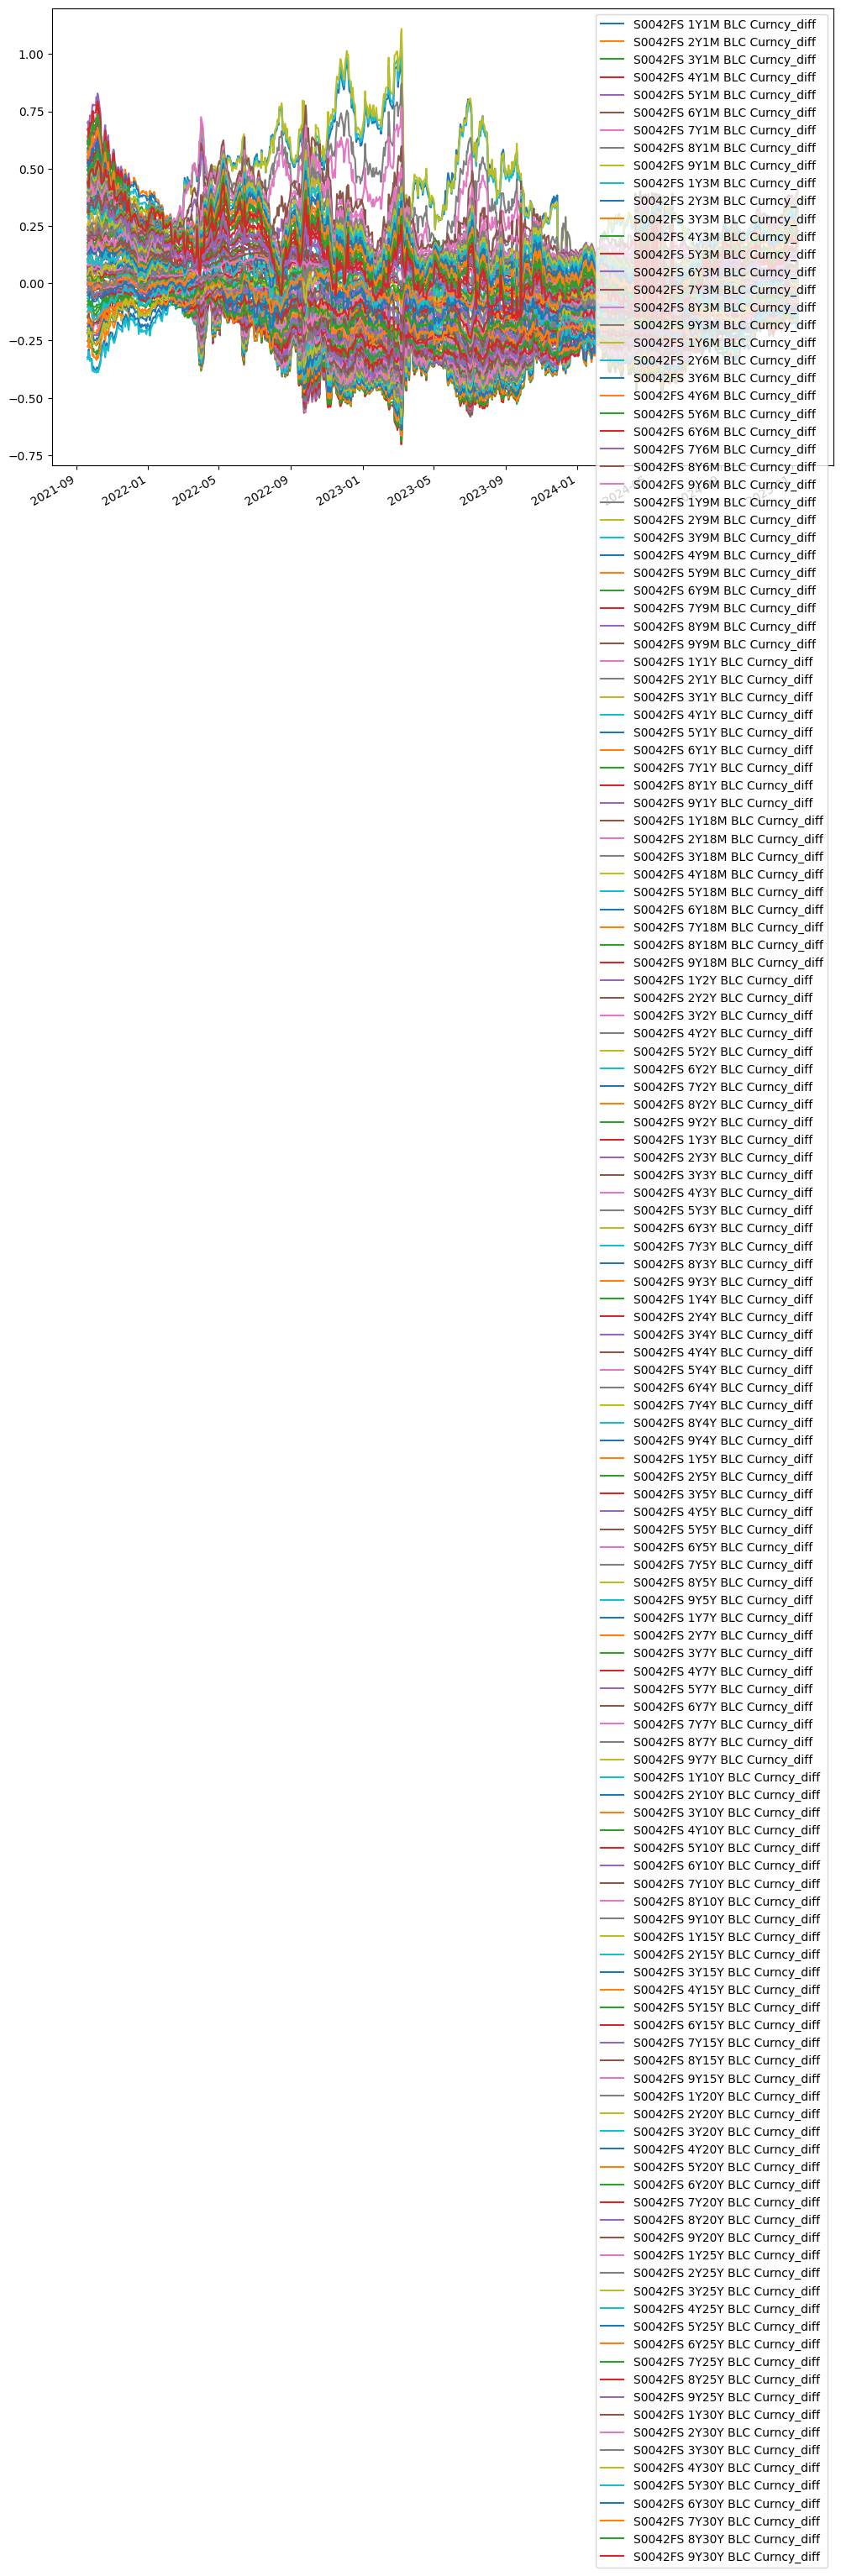

In [17]:
diff_df.plot(figsize=(12, 8))  # Adjust the size as needed
# Show the plot
plt.show()

### create the syntehtic forward rate file starting from 2015-01-01

In [18]:
first_date_sofr = df.index[-1]
forward_swap_rate_syn = forward_swap_rate[forward_swap_rate.index < first_date_sofr]
forward_swap_rate_syn.head()

,S0042FS 1Y1M BLC Curncy,S0042FS 2Y1M BLC Curncy,S0042FS 3Y1M BLC Curncy,S0042FS 4Y1M BLC Curncy,S0042FS 5Y1M BLC Curncy,S0042FS 6Y1M BLC Curncy,S0042FS 7Y1M BLC Curncy,S0042FS 8Y1M BLC Curncy,S0042FS 9Y1M BLC Curncy,S0042FS 1Y3M BLC Curncy,...,S0042FS 9Y25Y BLC Curncy,S0042FS 1Y30Y BLC Curncy,S0042FS 2Y30Y BLC Curncy,S0042FS 3Y30Y BLC Curncy,S0042FS 4Y30Y BLC Curncy,S0042FS 5Y30Y BLC Curncy,S0042FS 6Y30Y BLC Curncy,S0042FS 7Y30Y BLC Curncy,S0042FS 8Y30Y BLC Curncy,S0042FS 9Y30Y BLC Curncy
2013-02-01,-0.669462,-0.228389,0.149730,0.475373,0.756900,1.001064,1.213378,1.398388,1.559873,-0.504069,...,2.859511,2.788322,2.758862,2.729837,2.701282,2.673220,2.645674,2.618655,2.592176,2.566241
2013-02-05,-0.679537,-0.240947,0.135330,0.459627,0.740200,0.983718,1.195631,1.380436,1.541871,-0.515160,...,2.867031,2.796943,2.767832,2.739135,2.710887,2.683115,2.655838,2.629075,2.602834,2.577123
2013-02-06,-0.703403,-0.268176,0.105435,0.427616,0.706505,0.948686,1.159542,1.343513,1.504298,-0.540363,...,2.830487,2.761174,2.732279,2.703786,2.675730,2.648138,2.621031,2.594425,2.568333,2.542761
2013-02-07,-0.707441,-0.272155,0.101472,0.423633,0.702477,0.944593,1.155367,1.339245,1.499928,-0.544372,...,2.819110,2.749652,2.720705,2.692162,2.664059,2.636424,2.609276,2.582633,2.556504,2.530899
2013-02-08,-0.702553,-0.269170,0.102871,0.423699,0.701412,0.942562,1.152505,1.335664,1.495720,-0.540210,...,2.804702,2.735293,2.706354,2.677820,2.649726,2.622098,2.594959,2.568324,2.542204,2.516606


In [19]:
merged_forward_rate_df = pd.concat([df, forward_swap_rate_syn], axis=0)
merged_forward_rate_df.sort_index(inplace=True, ascending=False)
merged_forward_rate_df=merged_forward_rate_df[merged_forward_rate_df.index>="2015-01-01"]
merged_forward_rate_df.to_excel(dataDir+'syn_forward_sofr_swap_full_NEW.xlsx') # Header etc are later added manually
merged_forward_rate_df.tail()

,S0042FS 1Y1M BLC Curncy,S0042FS 2Y1M BLC Curncy,S0042FS 3Y1M BLC Curncy,S0042FS 4Y1M BLC Curncy,S0042FS 5Y1M BLC Curncy,S0042FS 6Y1M BLC Curncy,S0042FS 7Y1M BLC Curncy,S0042FS 8Y1M BLC Curncy,S0042FS 9Y1M BLC Curncy,S0042FS 1Y3M BLC Curncy,...,S0042FS 9Y25Y BLC Curncy,S0042FS 1Y30Y BLC Curncy,S0042FS 2Y30Y BLC Curncy,S0042FS 3Y30Y BLC Curncy,S0042FS 4Y30Y BLC Curncy,S0042FS 5Y30Y BLC Curncy,S0042FS 6Y30Y BLC Curncy,S0042FS 7Y30Y BLC Curncy,S0042FS 8Y30Y BLC Curncy,S0042FS 9Y30Y BLC Curncy
2015-01-08,0.959435,1.116421,1.255037,1.377532,1.485830,1.581584,1.666223,1.740991,1.806968,1.017338,...,2.088560,2.038454,2.016396,1.994543,1.972921,1.951552,1.930457,1.909650,1.889144,1.868950
2015-01-07,0.983437,1.126391,1.253015,1.365248,1.464754,1.552973,1.631155,1.700390,1.761635,1.036056,...,2.029446,1.982535,1.961639,1.940908,1.920368,1.900041,1.879949,1.860107,1.840529,1.821226
2015-01-06,1.000556,1.133517,1.251713,1.356845,1.450382,1.533598,1.607605,1.673376,1.731768,1.049386,...,2.023860,1.980198,1.960460,1.940836,1.921352,1.902035,1.882904,1.863977,1.845270,1.826795
2015-01-05,1.064857,1.205022,1.329356,1.439719,1.537712,1.624721,1.701949,1.770451,1.831148,1.116415,...,2.118546,2.072150,2.051408,2.030807,2.010375,1.990136,1.970111,1.950316,1.930768,1.911479
2015-01-02,1.051244,1.208085,1.346612,1.469065,1.577360,1.673143,1.757838,1.832683,1.898756,1.109099,...,2.187294,2.136500,2.114179,2.092056,2.070160,2.048514,2.027137,2.006045,1.985253,1.964771


## Evaluate Libor Sofr ATM difference

In [22]:
liborAtmFilePath = dataDir+'libor_atm_vol.xlsx'
# load sheet: impliedvoldata_ois
libordf = pd.read_excel(liborAtmFilePath, sheet_name='libor')
libordf.set_index(libordf.columns[0], inplace=True)

In [23]:
libordf = libordf.loc[:, ~libordf.columns.str.startswith('Unnamed')]
libordf = libordf.loc[:, ~libordf.columns.str.contains('I|1F')] # remove data that are missing
libordf.head()

,USSN0A1,USSN0A2,USSN0A3,USSN0A4,USSN0A5,USSN0A6,USSN0A7,USSN0A8,USSN0A9,USSN0C1,...,USSN259,USSN301,USSN302,USSN303,USSN304,USSN305,USSN306,USSN307,USSN308,USSN309
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-03,23.4,22.9,29.9,40.3,50.8,55.1,64.5,63.8,68.2,21.9,...,66.6,66.0,65.5,65.3,65.2,65.0,64.7,64.4,64.1,63.8
2013-01-04,23.3,22.8,29.8,40.1,50.5,54.9,64.2,63.5,67.8,22.0,...,66.4,65.8,65.3,65.2,65.0,64.9,64.6,64.3,63.9,63.6
2013-01-07,22.6,22.6,29.4,39.7,50.0,54.2,63.5,62.8,67.1,21.7,...,66.3,65.6,65.2,65.0,64.9,64.7,64.4,64.1,63.8,63.5
2013-01-08,22.4,22.4,29.2,39.2,49.1,53.5,62.6,62.2,66.5,21.4,...,66.3,65.6,65.2,65.0,64.9,64.7,64.4,64.1,63.8,63.5
2013-01-09,20.5,20.5,26.7,35.8,44.9,48.9,57.6,56.8,60.8,20.7,...,66.3,65.6,65.2,65.0,64.9,64.7,64.4,64.1,63.8,63.5


In [24]:
sofrAtmFilePath=dataDir+'swaption_atm_vol_full_NEW.xlsx'

sofrAtmDf = pd.read_excel(sofrAtmFilePath, skiprows=2, header=0)
sofrAtmDf = sofrAtmDf.rename(columns={'Ticker': 'Date'}).set_index('Date')
sofrAtmDf.head()

,USSNAA1 ICPL Curncy,USSNAA2 ICPL Curncy,USSNAA3 ICPL Curncy,USSNAA4 ICPL Curncy,USSNAA5 ICPL Curncy,USSNAA6 ICPL Curncy,USSNAA7 ICPL Curncy,USSNAA8 ICPL Curncy,USSNAA9 ICPL Curncy,USSNAC1 ICPL Curncy,...,USSNA259 ICPL Curncy,USSNA301 ICPL Curncy,USSNA302 ICPL Curncy,USSNA303 ICPL Curncy,USSNA304 ICPL Curncy,USSNA305 ICPL Curncy,USSNA306 ICPL Curncy,USSNA307 ICPL Curncy,USSNA308 ICPL Curncy,USSNA309 ICPL Curncy
Date,,,,,,,,,,,,,,,,,,,,,
2025-01-10,72.2,96.8,97.7,99.9,101.6,100.5,99.5,99.1,98.6,88.9,...,70.3,73.9,75.0,74.2,73.2,72.1,71.1,69.8,68.6,67.1
2025-01-09,79.9,101.1,102.2,103.3,104.5,103.2,101.8,101.3,100.8,88.5,...,69.7,73.1,74.2,73.5,72.4,71.4,70.4,69.1,67.9,66.4
2025-01-08,80.9,101.7,102.9,104.0,105.2,103.9,102.5,102.0,101.5,87.1,...,69.8,73.2,74.3,73.6,72.6,71.5,70.5,69.2,68.0,66.5
2025-01-07,83.5,104.4,105.7,107.1,109.2,107.5,105.7,104.7,103.7,86.7,...,69.7,73.1,74.2,73.5,72.5,71.4,70.5,69.1,68.0,66.5
2025-01-06,78.5,98.6,100.1,101.9,104.0,102.3,100.7,99.8,99.0,88.1,...,69.0,72.4,73.5,72.8,71.8,70.7,69.7,68.4,67.3,65.7


In [25]:

def sofr_column_to_libor_style(col_name: str) -> str:
    """
    Converts a column name from the SOFR format to the LIBOR style.

    Examples:
      "USSNA3M ICPL Curncy"  -> "USSN0A3M"  (when the base string length is 7)
      "USSNA30Y ICPL Curncy" -> "USSN A30Y"  (when the base string length is not 7)

    Process:
    1. Remove the trailing " ICPL Curncy".
    2. If the resulting base string has length 7, replace "USSNA" with "USSN0".
       Otherwise, replace "USSNA" with "USSN".
    """
    # Remove the trailing " ICPL Curncy"
    base = col_name.replace(" ICPL Curncy", "")

    # If the base string is exactly 7 characters long,
    # insert '0' after 'USSN'; otherwise, just replace "USSNA" with "USSN".
    if len(base) == 7:
        new = base.replace("USSNA", "USSN0")
    else:
        new = base.replace("USSNA", "USSN")

    return new


sofrAtmDf_renamed = sofrAtmDf.rename(columns=sofr_column_to_libor_style)
sofrAtmDf_renamed.head()


,USSN0A1,USSN0A2,USSN0A3,USSN0A4,USSN0A5,USSN0A6,USSN0A7,USSN0A8,USSN0A9,USSN0C1,...,USSN259,USSN301,USSN302,USSN303,USSN304,USSN305,USSN306,USSN307,USSN308,USSN309
Date,,,,,,,,,,,,,,,,,,,,,
2025-01-10,72.2,96.8,97.7,99.9,101.6,100.5,99.5,99.1,98.6,88.9,...,70.3,73.9,75.0,74.2,73.2,72.1,71.1,69.8,68.6,67.1
2025-01-09,79.9,101.1,102.2,103.3,104.5,103.2,101.8,101.3,100.8,88.5,...,69.7,73.1,74.2,73.5,72.4,71.4,70.4,69.1,67.9,66.4
2025-01-08,80.9,101.7,102.9,104.0,105.2,103.9,102.5,102.0,101.5,87.1,...,69.8,73.2,74.3,73.6,72.6,71.5,70.5,69.2,68.0,66.5
2025-01-07,83.5,104.4,105.7,107.1,109.2,107.5,105.7,104.7,103.7,86.7,...,69.7,73.1,74.2,73.5,72.5,71.4,70.5,69.1,68.0,66.5
2025-01-06,78.5,98.6,100.1,101.9,104.0,102.3,100.7,99.8,99.0,88.1,...,69.0,72.4,73.5,72.8,71.8,70.7,69.7,68.4,67.3,65.7


In [27]:
merged_sofrAtmDf_renamed = sofrAtmDf_renamed.join(libordf, rsuffix="_pred", how='inner')

for col in libordf.columns:
    # Create a new column for the difference
    merged_sofrAtmDf_renamed[f"{col}_diff"] = merged_sofrAtmDf_renamed[f"{col}"] - merged_sofrAtmDf_renamed[f"{col}_pred"]
    merged_sofrAtmDf_renamed[f"{col}_perdiff"] = (merged_sofrAtmDf_renamed[f"{col}"] - merged_sofrAtmDf_renamed[f"{col}_pred"])/merged_sofrAtmDf_renamed[f"{col}_pred"]

merged_sofrAtmDf_renamed.head()
sofrAtmDf_renamed[[col for col in sofrAtmDf_renamed.columns if 'I' in col]].head()

,USSN0I1,USSN0I2,USSN0I3,USSN0I4,USSN0I5,USSN0I6,USSN0I7,USSN0I8,USSN0I9
Date,,,,,,,,,
2025-01-10,112.0,114.2,111.7,110.3,108.8,107.1,105.7,104.5,103.7
2025-01-09,109.3,111.6,109.7,108.6,107.5,105.9,104.6,103.5,102.7
2025-01-08,107.9,110.7,109.1,108.1,107.2,105.8,104.7,103.7,103.0
2025-01-07,107.2,110.1,108.8,107.9,106.9,105.4,104.3,103.2,102.5
2025-01-06,107.7,110.3,108.4,107.4,106.5,105.0,103.9,102.7,102.0


#### get % spread dfference

In [28]:
# Identify difference in spread and use mean as the spread to adjust for values before first date
diff_atm_cols = [col for col in merged_sofrAtmDf_renamed.columns if col.endswith("perdiff")]
diff_atm_df = merged_sofrAtmDf_renamed[diff_atm_cols]
diff_atm_df.describe()

,USSN0A1_perdiff,USSN0A2_perdiff,USSN0A3_perdiff,USSN0A4_perdiff,USSN0A5_perdiff,USSN0A6_perdiff,USSN0A7_perdiff,USSN0A8_perdiff,USSN0A9_perdiff,USSN0C1_perdiff,...,USSN259_perdiff,USSN301_perdiff,USSN302_perdiff,USSN303_perdiff,USSN304_perdiff,USSN305_perdiff,USSN306_perdiff,USSN307_perdiff,USSN308_perdiff,USSN309_perdiff
count,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,...,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000
mean,-0.023000,-0.004174,-0.004800,-0.003594,-0.002892,-0.002525,-0.002181,-0.001807,-0.001419,-0.013839,...,-0.002093,0.003260,0.000574,-0.000207,-0.001004,-0.001580,-0.001619,-0.001558,-0.001541,-0.001603
std,0.024681,0.017994,0.013048,0.010643,0.009640,0.009081,0.008747,0.008690,0.008566,0.012340,...,0.003878,0.002488,0.003435,0.003688,0.003705,0.003942,0.004221,0.004602,0.004793,0.005112
min,-0.116517,-0.068802,-0.064792,-0.060168,-0.054827,-0.052443,-0.050060,-0.047676,-0.046484,-0.069643,...,-0.015625,-0.009434,-0.013233,-0.013462,-0.013592,-0.013725,-0.014210,-0.014363,-0.014467,-0.014679
25%,-0.026920,-0.014354,-0.012175,-0.009494,-0.008189,-0.007761,-0.007303,-0.007238,-0.006304,-0.014358,...,-0.005460,0.001907,-0.001890,-0.003660,-0.003899,-0.005372,-0.005666,-0.005780,-0.005848,-0.005888
50%,-0.015306,-0.007564,-0.007500,-0.003167,-0.001151,-0.000747,-0.000612,0.000000,0.000000,-0.010178,...,0.000000,0.003442,0.001701,0.001667,0.001647,0.000000,0.000000,0.000000,0.000000,0.000000
75%,-0.011250,0.010030,0.005131,0.002814,0.000000,0.000747,0.001520,0.002235,0.002917,-0.007125,...,0.001711,0.005051,0.003454,0.001963,0.001783,0.001715,0.001764,0.001813,0.001843,0.001885
max,0.105623,0.115869,0.112965,0.109898,0.112857,0.112623,0.112903,0.111297,0.107920,0.018625,...,0.023091,0.023256,0.023609,0.022184,0.022453,0.022767,0.024867,0.023381,0.023897,0.024436


#### Create libor atm difference based on % difference estimated above

In [32]:
merged_sofrAtmDf_renamed.index[-1]

Timestamp('2021-09-20 00:00:00')

In [34]:
mean_values = diff_atm_df.mean()
first_date = merged_sofrAtmDf_renamed.index[-1]
# Create libor data for period sofr not exist
libordf_syn = libordf[libordf.index < first_date]
libordf_syn.tail()

,USSN0A1,USSN0A2,USSN0A3,USSN0A4,USSN0A5,USSN0A6,USSN0A7,USSN0A8,USSN0A9,USSN0C1,...,USSN259,USSN301,USSN302,USSN303,USSN304,USSN305,USSN306,USSN307,USSN308,USSN309
Date,,,,,,,,,,,,,,,,,,,,,
2021-09-13,13.2,22.6,35.2,45.6,53.1,56.8,60.4,62.2,64.1,17.3,...,49.9,51.1,51.5,50.5,49.9,49.4,49.0,48.7,48.5,48.2
2021-09-14,12.9,22.0,34.0,44.2,50.9,54.8,58.4,60.4,62.4,17.1,...,49.8,51.0,51.4,50.4,49.9,49.3,49.0,48.7,48.4,48.2
2021-09-15,13.4,23.0,35.6,46.5,54.0,57.8,61.4,63.2,65.0,17.8,...,50.1,51.3,51.7,50.7,50.1,49.6,49.3,48.9,48.7,48.4
2021-09-16,13.3,22.9,35.5,46.3,53.8,57.6,61.1,63.0,64.8,19.4,...,49.9,51.2,51.6,50.5,50.0,49.4,49.1,48.7,48.5,48.2
2021-09-17,13.7,24.2,37.7,50.1,58.0,61.2,64.1,65.6,67.1,20.5,...,49.9,51.2,51.6,50.6,50.0,49.5,49.1,48.8,48.5,48.2


In [35]:
for col in libordf:
  # print(col,  mean_values[col+'_perdiff'], (1 + mean_values[col+'_perdiff']))
  libordf_syn[col]=libordf_syn[col]*(1 + mean_values[col+'_perdiff'])
libordf_syn.tail()

,USSN0A1,USSN0A2,USSN0A3,USSN0A4,USSN0A5,USSN0A6,USSN0A7,USSN0A8,USSN0A9,USSN0C1,...,USSN259,USSN301,USSN302,USSN303,USSN304,USSN305,USSN306,USSN307,USSN308,USSN309
Date,,,,,,,,,,,,,,,,,,,,,
2021-09-13,12.896403,22.505666,35.031029,45.436123,52.946445,56.656557,60.268254,62.087601,64.009036,17.060588,...,49.795545,51.266586,51.529556,50.489525,49.849916,49.321945,48.920667,48.624113,48.425239,48.122727
2021-09-14,12.603303,21.908171,33.836789,44.041154,50.752807,54.661608,58.272616,60.290854,62.311449,16.863356,...,49.695755,51.166260,51.429499,50.389546,49.849916,49.222103,48.920667,48.624113,48.325393,48.122727
2021-09-15,13.091803,22.903997,35.429108,46.332889,53.843842,57.654032,61.266073,63.085794,64.907759,17.553669,...,49.995127,51.467238,51.729671,50.689484,50.049716,49.521629,49.220181,48.823802,48.624931,48.322406
2021-09-16,12.994103,22.804414,35.329588,46.133607,53.644421,57.454537,60.966727,62.886155,64.708043,19.131527,...,49.795545,51.366912,51.629613,50.489525,49.949816,49.321945,49.020505,48.624113,48.425239,48.122727
2021-09-17,13.384903,24.098988,37.519028,49.919951,57.832275,61.045445,63.960183,65.481457,67.004779,20.216304,...,49.795545,51.366912,51.629613,50.589504,49.949816,49.421787,49.020505,48.723957,48.425239,48.122727


In [36]:
common_columns = libordf_syn.columns.intersection(sofrAtmDf_renamed.columns)
libordf_syn_filtered = libordf_syn[common_columns]
sofrAtmDf_renamed_filtered = sofrAtmDf_renamed[common_columns]
merged_df = pd.concat([libordf_syn_filtered, sofrAtmDf_renamed_filtered], axis=0)
merged_df=merged_df[merged_df.index>="2015-01-01"]
merged_df.sort_index(inplace=True, ascending=False)
merged_df.to_excel(dataDir+'syn_swaption_atm_vol_full_NEW.xlsx') # Header etc are later added manually
merged_df.tail()

,USSN0A1,USSN0A2,USSN0A3,USSN0A4,USSN0A5,USSN0A6,USSN0A7,USSN0A8,USSN0A9,USSN0C1,...,USSN259,USSN301,USSN302,USSN303,USSN304,USSN305,USSN306,USSN307,USSN308,USSN309
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-07,30.189307,65.525347,82.402533,86.886621,90.338002,89.573219,90.003253,87.940798,87.076255,44.771717,...,56.980474,57.085494,55.932081,55.588467,55.244496,54.913096,54.910953,54.814452,54.815374,54.811985
2015-01-06,36.930608,73.193207,88.373731,92.067934,94.725278,93.662865,93.894747,91.634112,90.671146,44.870333,...,56.581311,56.784516,55.531852,55.388509,55.144597,55.012938,54.910953,54.714608,54.615682,54.412627
2015-01-05,31.166307,61.741208,75.535655,78.815731,81.463739,80.595948,80.823321,78.857242,77.989169,43.884172,...,55.583404,55.781256,54.531278,54.388716,54.245500,54.014518,53.912572,53.716166,53.617223,53.514069
2015-01-02,30.287007,58.255818,70.360617,72.936934,75.381379,74.611100,74.736626,72.967904,72.197400,42.898011,...,55.383823,55.580604,54.331163,54.188758,53.945801,53.814834,53.712895,53.516478,53.417532,53.214550
2015-01-01,32.338707,59.849139,69.464937,72.040169,74.085138,73.414131,73.838589,72.069530,71.498393,43.391091,...,55.184242,55.379952,54.231105,53.988799,53.845902,53.714992,53.513219,53.416634,53.217840,53.114711


## Archived SOFR LIBOR RATE

This document aim to explore how to create synthetic SOFR rate based on LIBOR rate based on the guide: https://www.isda.org/a/fp8gE/Fallbacks_FAQ_V13_August-2024.pdf

There are two purposed method:
1. To directly use SOFR FALLBACK rate on Bloomberg as the syntehtic SOFR rate
2. Following the guide of ISDA, self - compute the median between SOFR and LIBOR for previous 5 year and use that as spread adjustment then self compound the rates

From cross checking, the SOFR Fallback(T+2) matches exactly with the overnight sofr rate and the method of computing median also generate very small spread. For simplicity, we'll use the SOFR Fallback rate to generate synthetic swaption data first.

However, later we find that the SOFR swap rate is already syntheticaly created on bloomberg for previous years, so we will directly use that one.

In [ ]:
# File name (adjust if your file is named differently, e.g. "3monLibor.xlsx")
overnightDataFilePath = "data/liborDataON.xlsx"  # if it's an Excel file with .csv extension, otherwise use .xlsx
sofrFallbackFilePath = "data/sofrFallback.xlsx"

# Load overnight data
df_libor_on    = pd.read_excel(overnightDataFilePath, sheet_name='US000N')
df_libor_on_fallback = pd.read_excel(overnightDataFilePath, sheet_name='VUS000N')
df_sofr_on     = pd.read_excel(overnightDataFilePath, sheet_name='SOFRRATE')
df_sofr_on_fallback     = pd.read_excel(sofrFallbackFilePath, sheet_name='XSOFRON')

# Ensure the 'date' columns are parsed as datetime objects
df_libor_on['date']    = pd.to_datetime(df_libor_on['Date'])
df_libor_on_fallback['date'] = pd.to_datetime(df_libor_on_fallback['Date'])
df_sofr_on['date']     = pd.to_datetime(df_sofr_on['Date'])
df_sofr_on_fallback['date']     = pd.to_datetime(df_sofr_on_fallback['Date'])

# Optionally sort by date if not already sorted
df_libor_on    = df_libor_on.sort_values('date')
df_libor_on_fallback = df_libor_on_fallback.sort_values('date')
df_sofr_on     = df_sofr_on.sort_values('date')
df_sofr_on_fallback = df_sofr_on_fallback.sort_values('date')

# Plotting the curves on the same figure
plt.figure(figsize=(14, 7))
plt.plot(df_libor_on['date'], df_libor_on['Ask Price'], label='LIBOR on US000N (Ask Price)', linewidth=2)
plt.plot(df_libor_on_fallback['date'], df_libor_on_fallback['Mid Price'], label='LIBOR Fallback on US000N (Mid Price)', linewidth=2)
plt.plot(df_sofr_on['date'], df_sofr_on['Mid Price'], label='SOFR on SOFRRATE (Mid Price)', linewidth=2)
plt.plot(df_sofr_on_fallback['date'], df_sofr_on_fallback['Mid Price'], label='SOFR Fallback Rate ON (Mid Price)', linewidth=2)

plt.xlabel("Date")
plt.ylabel("Rate")
plt.title("Interest Rate Curves")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
merged_df = pd.merge(
    df_sofr_on_fallback[['date', 'Mid Price']],
    df_sofr_on[['date', 'Mid Price']],
    on='date',
    how='inner',
    suffixes=('_sofr_fallback', '_sofr')
)
merged_df['diff']=merged_df['Mid Price_sofr_fallback']-merged_df['Mid Price_sofr']
print(merged_df)

In [ ]:
merged_df[abs(merged_df['diff'])>1]

Adjust rate to accomodation for sofr being calculated in arrear and libor being forward looking rate.Considering T+2 being settlement rate and by observing the curve, we shift sofr 2 days forward (i.e put sofr on 2018-04-01 to 2018-04-04)

In [ ]:
merged_df['date'] = pd.to_datetime(merged_df['date'])
merged_df = merged_df.sort_values('date').reset_index(drop=True)
merged_df['Mid Price_sofr_shifted'] = merged_df['Mid Price_sofr'].shift(+2) # cuz T+2 settlement
merged_df['shifted_diff']=merged_df['Mid Price_sofr_fallback']-merged_df['Mid Price_sofr_shifted']
# merged_df['capped diff'] = merged_df['diff'].clip(lower=-1, upper=1)
merged_df

In [ ]:
# Plotting the curves on the same figure
plt.figure(figsize=(10, 5))
# plt.plot(df_libor['date'], df_libor['Ask Price'], label='LIBOR on US000N (Ask Price)', linewidth=2)
plt.plot(merged_df['date'], merged_df['diff'], label='difference between fallback and sofr', linewidth=2)
plt.plot(merged_df['date'], merged_df['shifted_diff'], label='difference between fallback and sofr_shifted', linewidth=2)

plt.xlabel("Date")
plt.ylabel("%")
plt.title("Difference")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot the shifted_diff on the first subplot
axs[0].plot(merged_df['date'], merged_df['shifted_diff'], label='Shifted Diff', linewidth=2)
axs[0].set_xlabel("Date")
axs[0].set_ylabel("%")
axs[0].set_title("Difference: Shifted")
axs[0].legend()
axs[0].grid(True)

# Plot the capped diff on the second subplot
axs[1].plot(merged_df['date'], merged_df['diff'], label='diff', linewidth=2, color='orange')
axs[1].set_xlabel("Date")
axs[1].set_ylabel("%")
axs[1].set_title("Difference: without shiift")
axs[1].legend()
axs[1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [ ]:
merged_df.describe()

By checking the shifted_diff, we do see that the difference mean and standarddeviation are both around ~1bps.

## Method 2


In [ ]:
merged_spread = pd.merge(
    df_libor_on[['date', 'Ask Price']],
    df_sofr_on[['date', 'Mid Price']],
    on='date',
    how='inner',
    suffixes=('_libor', '_sofr')
)
days = str(252*5)+'D'
# Calculate the daily spread: LIBOR Ask Price minus SOFR Mid Price
merged_spread['spread'] = merged_spread['Ask Price'] - merged_spread['Mid Price']

# Set the date column as the index to enable time-based rolling window
merged_spread = merged_spread.sort_values('date').set_index('date')

# Compute the rolling median spread over a 5-year window (approx. 1825 days)
merged_spread['rolling_spread'] = merged_spread['spread'].rolling(days).median()
merged_spread['synthetic_sofr_on'] = merged_spread['Ask Price']-merged_spread['spread']
merged_spread['diff'] = merged_spread['synthetic_sofr_on']-merged_spread['Mid Price']

# Optionally, reset the index if you need 'date' as a column later:
merged_spread.reset_index(inplace=True)

print(merged_spread.head())

In [ ]:
merged_spread.describe()